In [561]:
import ast
from pathlib import Path

import contextily as cx
import geopandas as gpd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox
import pandas as pd
# import pysal
import seaborn as sns
from geopy.geocoders import ArcGIS
# from pyproj import CRS
# from sklearn.cluster import DBSCAN
# from ipywidgets import interact, fixed

In [2]:
data_path = Path("../db/data")

El municipio donde vamos a hacer la ciudad en 15 minutos

In [ ]:
addr = "San Vicente del Raspeig, Alicante, Spain"

### Leo las coordenadas de todo lo que tengo alrededor

In [617]:
# coordenadas de los municipios
coords = Path(data_path,"coords_municipios.csv")
df_coords = pd.read_csv(coords, sep="\t")

# coordenadas de los centros de educaci'on
centros_educacion = Path(data_path, "centros_educacion.csv")
df_edu = pd.read_csv(centros_educacion, sep="\t")
df_edu.drop(columns=["attr_url", 
                     "attr_comedor", 
                     "attr_horario_ampliado", 
                     "attr_transporte",
                     "attr_multi_lengua",
                     "attr_telephone",
                     "attr_fax",
                     "attr_mail",
                     "attr_webpage"
                    ], inplace=True)
df_edu = df_edu[df_edu.province == "alicante"]
df_edu = df_edu[df_edu.city == "san vicente del raspeig/sant vicent del raspeig"]

# coordenadas de los ayuntamientos
ayuntamientos = Path(data_path, "ayuntamientos_final.csv")
df_ayun = pd.read_csv(ayuntamientos, sep="\t")
df_ayun["cp"] = df_ayun["cp"].apply(lambda x: str(int(x)).zfill(5))
df_ayun = df_ayun[df_ayun.cp == "03690"]

# coordenadas de las comisar'ias

# coordenadas de los centros de correos
correos = Path(data_path, "correos.csv")
df_corr = pd.read_csv(correos, sep="\t")
df_corr["cp"] = df_corr["cp"].apply(lambda x: str(int(x)).zfill(5))
df_corr = df_corr[df_corr.cp == "03690"]

# coordenadas de las farmacias
farmacias = Path(data_path, "farmacias.csv")
df_far = pd.read_csv(farmacias, sep="\t")
df_far.drop(columns=["url", "telephone", "web"], inplace=True)
df_far = df_far[~df_far["city"].isna()]
df_far = df_far[df_far["city"].apply(lambda x: x.lower().startswith("san vicente del rasp"))]
df_far["cp"] = df_far["cp"].apply(lambda x: str(int(x)).zfill(5))

# coordenadas de las gasolineras
gasolineras = Path(data_path, "gasolineras.csv")
df_gaso = pd.read_csv(gasolineras, sep="\t")
df_gaso["c.p."] = df_gaso["c.p."].apply(lambda x: str(int(x)).zfill(5))
df_gaso.latitud = df_gaso.latitud.apply(lambda x: ast.literal_eval(x.replace(",", ".")))
df_gaso.longitud = df_gaso.longitud.apply(lambda x: ast.literal_eval(x.replace(",", ".")))
df_gaso = df_gaso[df_gaso["c.p."] == "03690"]

# coordenadas de los puestos de la GC
cuarteles = Path(data_path, "puestos_gc.csv")
df_gc = pd.read_csv(cuarteles, sep="\t")
df_gc["cp"] = df_gc["cp"].apply(lambda x: str(int(x)).zfill(5) if x > 1 else x)
df_gc = df_gc[df_gc.cp == "03690"]

# coordenadas de los hospitales
hospitales = Path(data_path, "sanidad_hospital.csv")
df_hospi = pd.read_csv(hospitales, sep="\t")
df_hospi["Código Postal"] = df_hospi["Código Postal"].apply(lambda x: str(int(x)).zfill(5))
df_hospi = df_hospi[df_hospi["Código Postal"] == "03690"]

# coordenadas de los centros de atenci'on primaria
ambulatorios = Path(data_path, "sanidad_primaria.csv")
df_sani = pd.read_csv(ambulatorios, sep="\t")
df_sani["CP"] = df_sani["CP"].apply(lambda x: str(int(x)).zfill(5))
df_sani = df_sani[df_sani.CP == "03690"]

# coordenadas de las universidades

# coordenadas de las empresas
for i in range(43):
    empresas = Path(data_path, f"empresas_{i}.csv")
    df_emp = pd.read_csv(empresas, sep="\t")
    df_emp["cp"] = df_emp["cp"].apply(lambda x: str(int(x)).zfill(5) if x > 1 else x)
    break

In [616]:
# df_hospi[df_hospi["Código Postal"] == "03690"]
# 38.40352706310931, -0.5307836325313446

,CCN,CODCNH,Nombre Centro,Dirección,Teléfono,Cód. Municipio,Municipio,Cód. Provincia,Provincia,Cód. CCAA,...,Clase de Centro,Cód. Dep. Funcional,Dependencia Funcional,Forma parte Complejo,CODIDCOM,Nombre del Complejo,ALTA,Email,latitude,longitude
641,1003000121,30187,Hospital Sant Vicent del Raspeig,Calle Lillo Juan 137,965907700,31225,San Vicente del Raspeig/Sant Vicent del Raspeig,3,Alicante,10,...,Hospitales de media y larga estancia,2,Servicios e Institutos de Salud de Las Comunid...,N,NaN,NaN,N,hospitalsanvicente@gva.es,38.403909,-0.529773


In [4]:
df_local = df_coords[df_coords["Población"].apply(lambda x: x.lower().startswith("san vicente del rasp"))]
lat = df_local.loc[:,"Latitud"]
long = df_local.loc[:,"Longitud"]


df_local

,Comunidad,Provincia,Población,Latitud,Longitud,Altitud,Habitantes,Hombres,Mujeres
7689,Valencia,Alicante/Alacant,San Vicente del Raspeig/Sant Vicent del Raspeig,38.39609,-0.524928,113.718,53126,26404,26722


In [625]:
df_edu.loc[994, ["latitude", "longitude"]] = 38.39560705894477, -0.5089468079920636
df_edu.loc[1041, ["latitude", "longitude"]] = 38.39116543296527, -0.5008776391359979
df_edu.loc[1045, ["latitude", "longitude"]] = 38.39709324193873, -0.522466355396303
df_edu.loc[1054, ["latitude", "longitude"]] = 38.38936081453725, -0.520974881365506
df_edu.loc[1085, ["latitude", "longitude"]] = 38.38234088870766, -0.5007578944172216
df_edu.loc[1117, ["latitude", "longitude"]] = 38.40026209341304, -0.5161450356560767
df_edu.loc[1135, ["latitude", "longitude"]] = 38.38309095325863, -0.5028496277542166
df_edu.loc[1147, ["latitude", "longitude"]] = 38.39795527680875, -0.5322298829441259
df_edu.loc[1164, ["latitude", "longitude"]] = 38.39632081641898, -0.5155236661985986
df_edu.loc[1208, ["latitude", "longitude"]] = 38.39276131694594, -0.5142464682583949
df_edu.loc[1220, ["latitude", "longitude"]] = 38.39594318263856, -0.5228168033796643
df_edu.loc[1228, ["latitude", "longitude"]] = 38.40719866438324, -0.49469388492382205
df_edu.loc[1406, ["latitude", "longitude"]] = 38.406200579983654, -0.5266188440722067
df_edu.loc[1407, ["latitude", "longitude"]] = 38.40311990158466, -0.5276423650971032
df_edu.loc[1544, ["latitude", "longitude"]] = 38.40147956399211, -0.5201231903046019
df_edu.loc[1664, ["latitude", "longitude"]] = 38.41939922945719, -0.5305526301009513
df_edu.loc[1669, ["latitude", "longitude"]] = 38.407002624828266, -0.5271717257961379
df_edu.loc[1710, ["latitude", "longitude"]] = 0.0, 0.0
df_edu.loc[1721, ["latitude", "longitude"]] = 38.40421349689192, -0.529603740011475
df_edu.loc[1734, ["latitude", "longitude"]] = 38.39712218884253, -0.5273002553352634
df_edu.loc[1745, ["latitude", "longitude"]] = 38.389741905786856, -0.5210568110892512
df_edu.loc[1758, ["latitude", "longitude"]] = 38.39691385973295, -0.527680377818451
df_edu.loc[1764, ["latitude", "longitude"]] = 0.0, 0.0
# df_edu

In [626]:
df_far.loc[13519, ["latitude", "longitude"]] = 38.391150592575734, -0.5048953931204911
df_far.loc[14472, ["latitude", "longitude"]] = 38.39655724603255, -0.5145309650811363
df_far.loc[14477, ["latitude", "longitude"]] = 38.39997329862938, -0.5182495854082957
df_far.loc[16203, ["latitude", "longitude"]] = 38.39502955315631, -0.518248173991183
df_far.loc[16204, ["latitude", "longitude"]] = 38.395160589313065, -0.5213900361142382
df_far.loc[16205, ["latitude", "longitude"]] = 38.38227099947753, -0.5039155916126801
df_far.loc[16206, ["latitude", "longitude"]] = 0.0, 0.0
df_far.loc[16207, ["latitude", "longitude"]] = 0.0, 0.0
df_far.loc[16208, ["latitude", "longitude"]] = 38.39579462503511, -0.5243424615739515
df_far.loc[16210, ["latitude", "longitude"]] = 38.398088781272854, -0.5228757748205589
df_far.loc[16211, ["latitude", "longitude"]] = 38.40275123345296, -0.5289581525055659
df_far.loc[16212, ["latitude", "longitude"]] = 38.401034065049565, -0.5255928335346702
df_far.loc[16213, ["latitude", "longitude"]] = 38.3986098769834, -0.5198628611819298
df_far.loc[16214, ["latitude", "longitude"]] = 38.39244184137097, -0.5217053161473841
df_far.loc[16215, ["latitude", "longitude"]] = 38.399570470553044, -0.5296470261371787
df_far.loc[16216, ["latitude", "longitude"]] = 38.40115738434616, -0.5223693746597631
df_far.loc[16217, ["latitude", "longitude"]] = 38.40302896348741, -0.5268234942263659
df_far.loc[10001, ["latitude", "longitude", "name", "address"]] = 38.39524873065284, -0.5278276637732634, "FARMACIA BROTONS OLIVER".lower(), "CALLE MADRID, 16".lower()
df_far.loc[10002, ["latitude", "longitude", "name", "address"]] = 38.39502185926838, -0.5157405207246476, "Farmacia Martin Zamora".lower(), "C. la Huerta, 152".lower()
df_far.loc[10003, ["latitude", "longitude", "name", "address"]] = 38.398727272344544, -0.5257844907477707, "SOROLLA".lower(), "C. Pintor Sorolla, 26".lower()
df_far.loc[10004, ["latitude", "longitude", "name", "address"]] = 38.391631874379584, -0.5165202045716735, "Farmacia Montoya".lower(), "C/ Alicante, 82".lower()
# df_far

In [627]:
df_ayun.loc[7496, ["latitude", "longitude"]] = 38.39552018048025, -0.5222930320970816
# df_ayun

In [628]:
df_corr.loc[62, ["latitude", "longitude"]] = 38.397251571839966, -0.5221378320970325
# df_corr

In [589]:
# df_gaso

In [629]:
df_gc.loc[144, ["latitud", "longitud"]] =38.39798027166971, -0.5273640388447594
# df_gc

In [630]:
df_sani.loc[10473, ["latitude", "longitude"]] = 38.39203538601938, -0.5171350348837962
df_sani.loc[10474, ["latitude", "longitude"]] = 38.40419276235811, -0.5308010473180867
df_sani.loc[10476, ["latitude", "longitude"]] = 38.383570129279626, -0.503257107537275
# df_sani

In [631]:
df_hospi.loc[641, ["latitude", "longitude"]] = 38.40352706310931, -0.5307836325313446
# df_hospi

El grafo desde la direccion dada

In [460]:
gdf = ox.geocode_to_gdf(addr)
G = ox.graph_from_place(addr, network_type="drive", retain_all=True)

# get building footprints
fp = ox.features_from_place(addr, {"building": True})

PRUEBAS

In [202]:
gpd_far = gpd.GeoDataFrame(
    {
        "geometry": gpd.points_from_xy(
            df_far["longitude"], df_far["latitude"]
        )
    }, crs="EPSG:4326"
)

In [203]:
gpd_far

,geometry
0,POINT (-0.52508 38.34810)
1,POINT (-0.51449 38.39660)
2,POINT (-0.51823 38.39990)
3,POINT (-0.51804 38.39530)
4,POINT (-0.52136 38.39510)
5,POINT (-0.50260 38.38169)
6,POINT (-0.52264 38.39120)
7,POINT (-0.50659 38.39180)
8,POINT (-0.52435 38.39580)
9,POINT (-0.52301 38.39810)


Ahora tenemos que poner las aristas

### Grafo desde OSM y todas las amenities

In [136]:
# city = ox.geocode_to_gdf(addr)

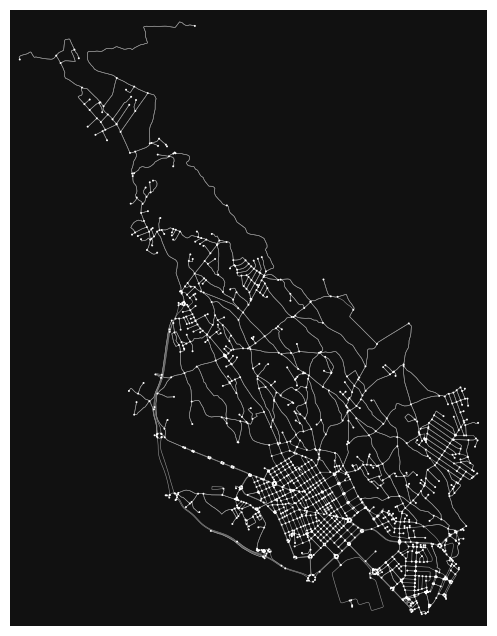

/opt/conda/lib/python3.11/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 30 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


<Figure size 640x480 with 0 Axes>

In [363]:
# https://osmnx.readthedocs.io/en/stable/user-reference.html
G0 = ox.graph_from_place(addr, network_type="drive")
fig, ax = ox.plot_graph(G0,
                        edge_linewidth=0.4,
                        node_size=2,
                       )
cx.add_basemap(ax=ax, url=cx.providers.CartoDB.Positron)

# city_proj = ox.projection.project_gdf(city)
# city_proj.plot(ax=ax, fc="k", ec="#666666", lw=1, alpha=1, zorder=-1)

In [312]:
gdf = ox.geocode_to_gdf(addr)
G = ox.graph_from_place(addr, network_type="drive", retain_all=True)

# get building footprints
fp = ox.features_from_place(addr, {"building": True})

<Axes: >

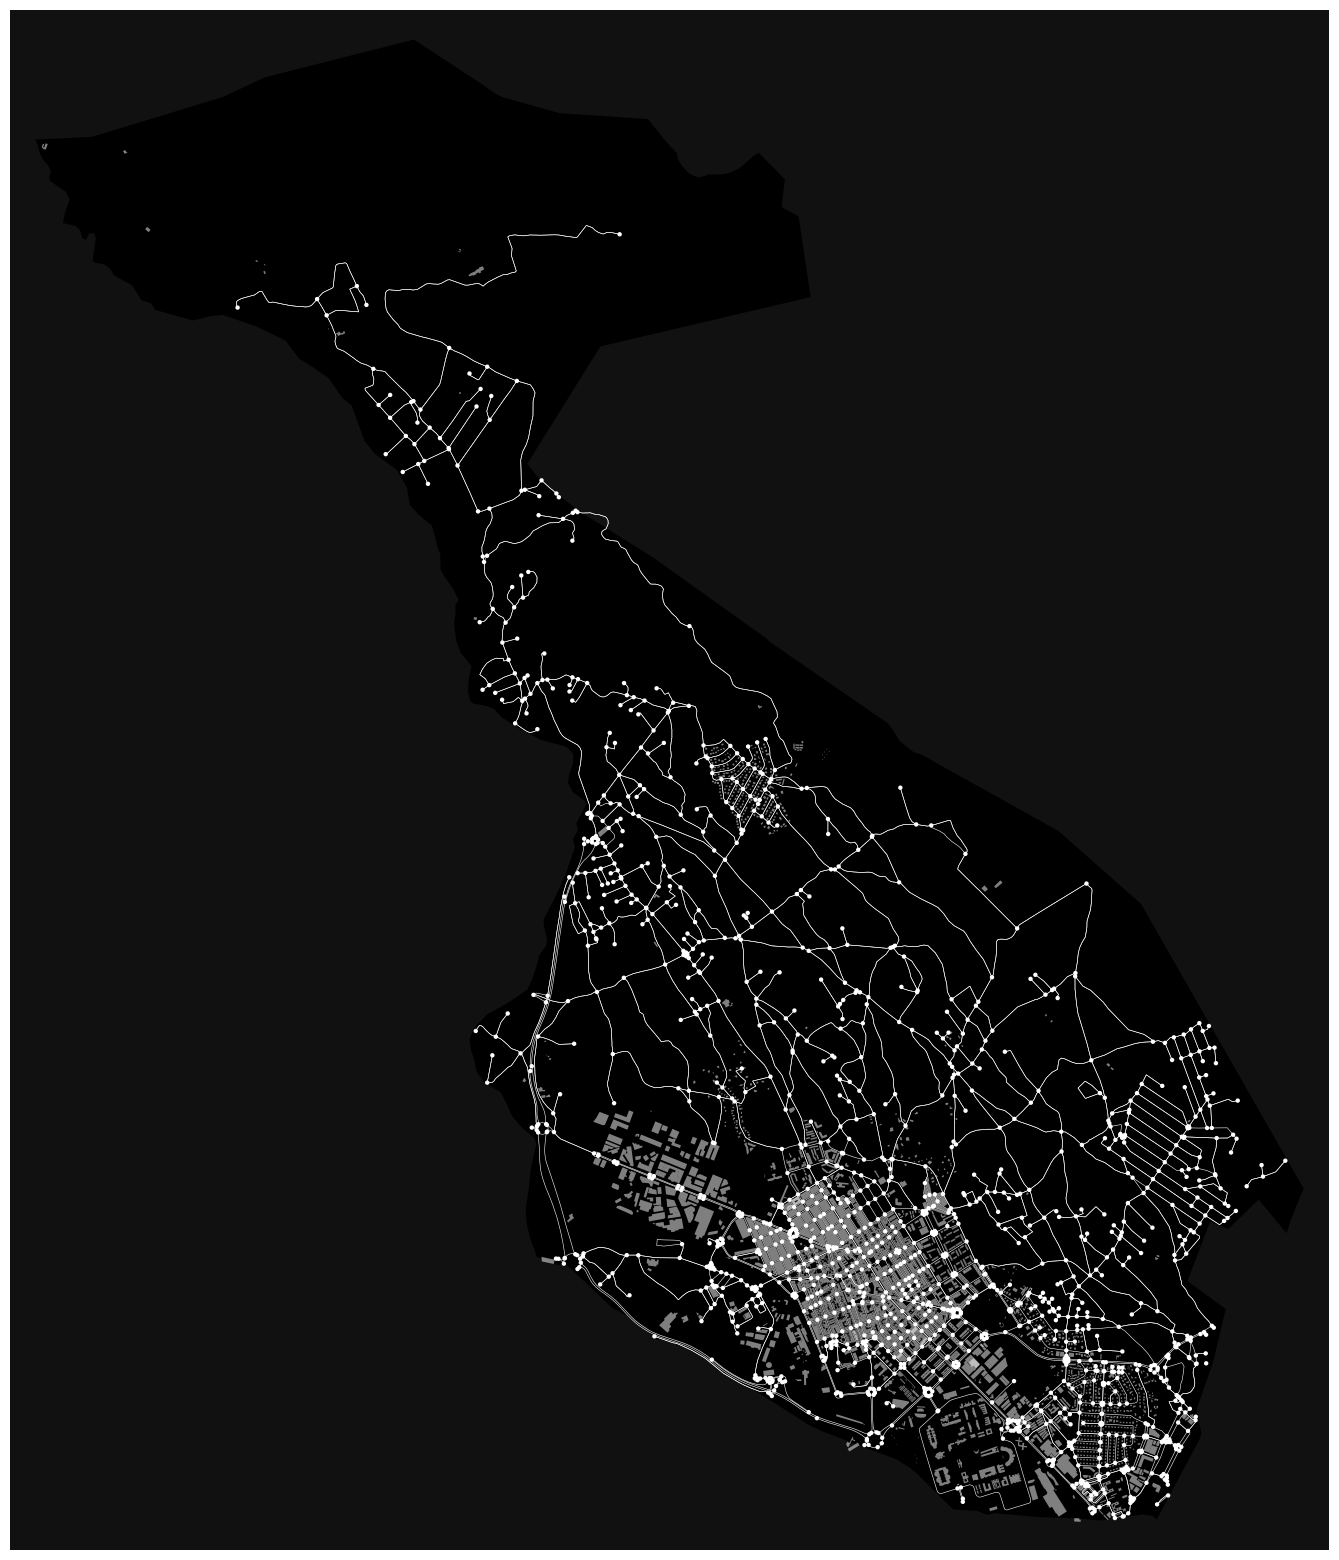

In [298]:
# plot the network, but do not show it or close it yet
fig, ax = ox.plot_graph(
    G,
    show=False,
    close=False,
    # bgcolor="#333333",
    edge_color="w",
    edge_linewidth=0.4,
    node_size=10,
    dpi=180,
    figsize=(20,20),
    # save=True, 
    # filepath='sanvi.png'
)

# to this matplotlib axis, add the place shape(s)
ax2 = gdf.plot(ax=ax, fc="k", ec="none", lw=1, alpha=1, zorder=-1)
# gdf = gdf.to_crs(epsg=4326)

# nodes color


# optionally set up the axes extents
margin = 0.02
west, south, east, north = gdf.unary_union.bounds
margin_ns = (north - south) * margin
margin_ew = (east - west) * margin
ax.set_ylim((south - margin_ns, north + margin_ns))
ax.set_xlim((west - margin_ew, east + margin_ew))

# los edificios
fp.plot(ax=ax, color='w', alpha=0.5)

# cx.add_basemap(
#     ax=ax2,
#     crs="EPSG:4326",
#     source=cx.providers.CartoDB.PositronNoLabels,
# )
# plt.show()
# plt.savefig("sanvi.png")

convertimos el grafo a geopandas para hacer cálculos

In [171]:
gdf_svr_nodes, gdf_svr_edges = ox.graph_to_gdfs(G)
gdf_svr_nodes.head()

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
13844375,38.385888,-0.522504,3,NaN,NaN,POINT (-0.52250 38.38589)
13844606,38.385275,-0.521419,3,NaN,NaN,POINT (-0.52142 38.38528)
196037389,38.382262,-0.514533,3,NaN,NaN,POINT (-0.51453 38.38226)
196037518,38.385457,-0.522715,3,NaN,NaN,POINT (-0.52272 38.38546)
196037542,38.385005,-0.521780,3,NaN,NaN,POINT (-0.52178 38.38501)


In [172]:
gdf_svr_edges.head()

osmid lanes  \
u         v          key                                                     
13844375  2466639673 0                                      18943650     2   
          2466639829 0                                      24239995     2   
13844606  196037556  0                                      18943650     2   
196037389 211270950  0    [31563483, 20024379, 694346892, 694346891]     2   
196037518 262654720  0                                      18943650     2   

                            ref   highway maxspeed    junction  oneway  \
u         v          key                                                 
13844375  2466639673 0    A-77a   primary       40  roundabout    True   
          2466639829 0    A-77a   primary       80         NaN    True   
13844606  196037556  0    A-77a   primary       40  roundabout    True   
196037389 211270950  0      NaN  tertiary       20         NaN    True   
196037518 262654720  0    A-77a   primary       40  roundabout    True   

                         reversed    length  \
u         v          key                      
13844375  2466639673 0      False    41.435   
          2466639829 0      False   490.416   
13844606  196037556  0      False    41.846   
196037389 211270950  0      False  1242.588   
196037518 262654720  0      False    35.813   

                                                                   geometry  \
u         v          key                                                      
13844375  2466639673 0    LINESTRING (-0.52250 38.38589, -0.52261 38.385...   
          2466639829 0    LINESTRING (-0.52250 38.38589, -0.52268 38.385...   
13844606  196037556  0    LINESTRING (-0.52142 38.38528, -0.52137 38.385...   
196037389 211270950  0    LINESTRING (-0.51453 38.38226, -0.51428 38.382...   
196037518 262654720  0    LINESTRING (-0.52272 38.38546, -0.52269 38.385...   

                         name bridge tunnel width  
u         v          key                           
13844375  2466639673 0    NaN    NaN    NaN   NaN  
          2466639829 0    NaN    NaN    NaN   NaN  
13844606  196037556  0    NaN    NaN    NaN   NaN  
196037389 211270950  0    NaN    NaN    NaN   NaN  
196037518 262654720  0    NaN    NaN    NaN   NaN

In [477]:
df_far.head()

,name,address,longitude,latitude,city,province,cp
13519,Farmacia Sol y Luz-Girasoles,"Carrer Riu Turia, 23",-0.506015,38.39124,San Vicente del Raspeig,Alacant,03690
14472,Farmacia Herederos de Pedro Rupérez Montserrat,"Avinguda D L`almássera, 19",-0.514488,38.39660,San Vicente Del Raspeig,Alacant,03690
14477,Farmacia la Almazara,"Calle la Huerta, 11",-0.518230,38.39990,San Vicente Del Raspeig,Alacant,03690
16203,Farmacia Cayetano Gutiérrez Solano,"Calle Pelayo, 14",-0.518040,38.39530,San Vicente Del Raspeig,Alacant,03690
16204,Cesar Savall Ceres,"Calle Aviacion, 2",-0.521360,38.39510,San Vicente del Raspeig,Alacant,03690


In [520]:
# df_edu

### Introducir las infraestructuras desde los CSV

In [632]:
# recorro los nodos de las farmacias
G2 = G.copy()

for index, row in df_edu.iterrows():
    G2.add_node(f"educa_{index}", y= row.latitude, x= row.longitude, street_count = 2)
    
for index, row in df_far.iterrows():
    G2.add_node(f"farma_{index}", y= row.latitude, x= row.longitude, street_count = 2)

for index, row in df_sani.iterrows():
    G2.add_node(f"sanidad_{index}", y= row.latitude, x= row.longitude, street_count = 2)

for index, row in df_hospi.iterrows():
    G2.add_node(f"hospital_{index}", y= row.latitude, x= row.longitude, street_count = 2)

for index, row in df_gaso.iterrows():
    G2.add_node(f"gasol_{index}", y= row.latitud, x= row.longitud, street_count = 2)

for index, row in df_gc.iterrows():
    G2.add_node(f"puestos_{index}", y= row.latitud, x= row.longitud, street_count = 2)

for index, row in df_ayun.iterrows():
    G2.add_node(f"ayunta_{index}", y= row.latitude, x= row.longitude, street_count = 2)

for index, row in df_corr.iterrows():
    G2.add_node(f"correos_{index}", y= row.latitude, x= row.longitude, street_count = 2)

    # break
# https://stackoverflow.com/questions/72523683/add-node-between-existing-edge-in-networkx-graph-generated-by-osmnx
# lat = 38.39123977120418
# long = -0.5060148787288844
# a, d = ox.distance.nearest_nodes(G, long, lat, return_dist = True)
# f, t, _ = a

# ne or (ne, dist) – nearest edges as (u, v, key) or optionally a tuple where dist contains distances between the points and their nearest edges
# print(ox.distance.nearest_edges(G, long, lat, return_dist = True))
# nn or (nn, dist) – nearest node IDs or optionally a tuple where dist contains distances between the points and their nearest nodes
# print(ox.distance.nearest_nodes(G, long, lat, return_dist = True))

# edge_attrs = G[f][t]
# c = "farma"
# G.add_node(c, y= lat, x= long, street_count = 2)

# G.add_edge(f, c, **{**edge_attrs, 'length': d(f, c)})
# G.add_edge(c, t, **{**edge_attrs, 'length': d(c, t)})
    
    

In [633]:
gdf_nodes2, gdf_edges2 = ox.graph_to_gdfs(G2)

In [485]:
# gdf_nodes2.tail(20)

In [482]:
# gdf_nodes2.explore()

In [634]:
n_color = list()
n_size = list()
for i in gdf_nodes2.index:
    if "farma" in str(i) or "sani" in str(i) or "hospital" in str(i):
        n_color.append("lime")
        n_size.append(10)
    elif "educa" in str(i):
        n_color.append("r")
        n_size.append(10)
    elif "gasol" in str(i) or "ayunta" in str(i) or "correos" in str(i) or "puestos" in str(i):
        n_color.append("black")
        n_size.append(10)
    else:
        n_color.append("w")
        n_size.append(1)

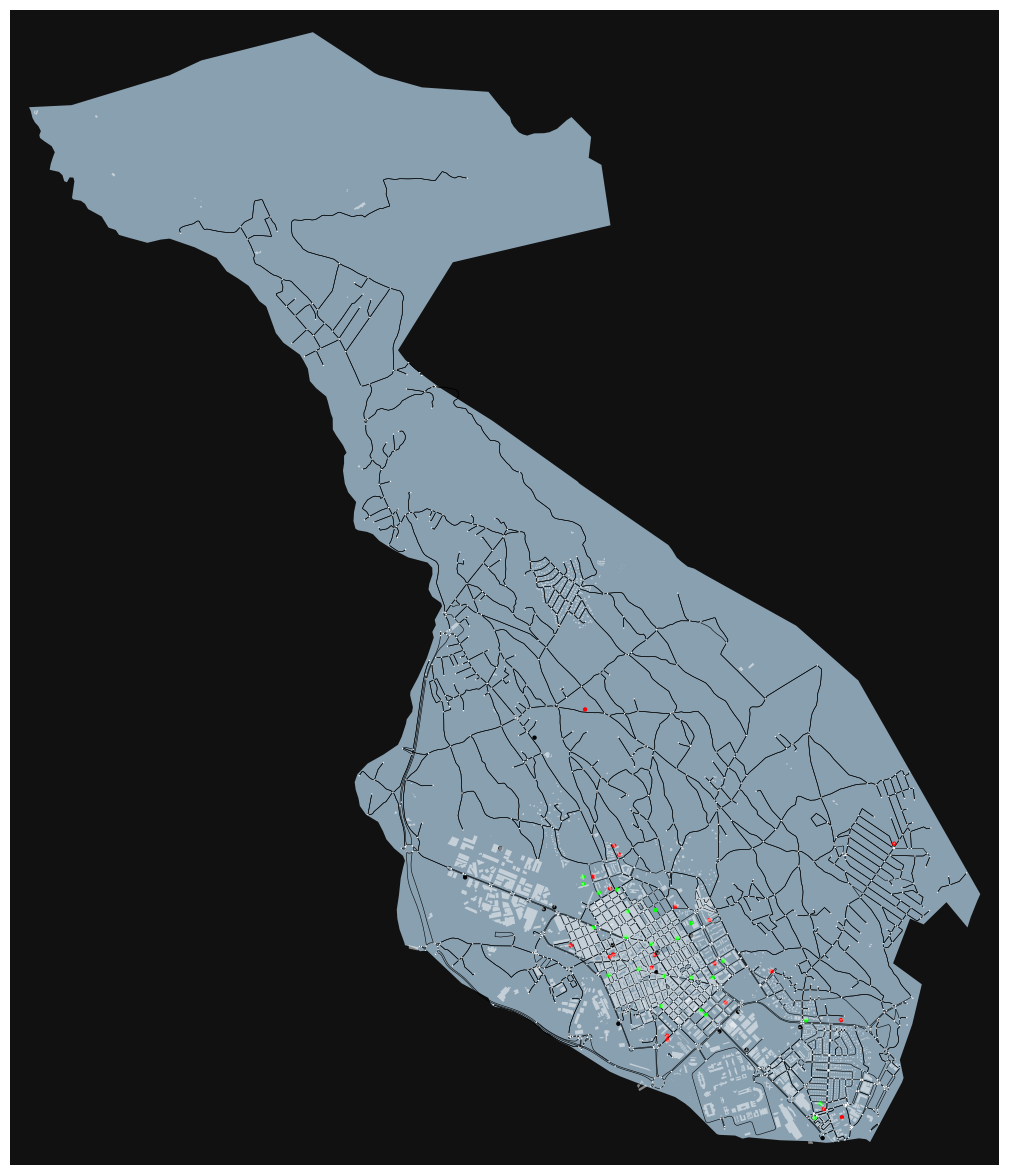

In [635]:
fig, ax = ox.plot_graph(
    G2,
    show=False,
    close=False,
    # bgcolor="#333333",
    edge_color="black",
    edge_linewidth=0.4,
    # node_size=10,
    node_size=n_size,
    dpi=180,
    figsize=(15,15),
    node_color=n_color,
    # save=True, 
    # filepath='sanvi.png'
)

# to this matplotlib axis, add the place shape(s)
ax2 = gdf.plot(ax=ax, fc="#89a0b0", ec="none", lw=1, alpha=1, zorder=-1)
gdf = gdf.to_crs(epsg=4326)

# optionally set up the axes extents
margin = 0.02
west, south, east, north = gdf.unary_union.bounds
margin_ns = (north - south) * margin
margin_ew = (east - west) * margin
ax.set_ylim((south - margin_ns, north + margin_ns))
ax.set_xlim((west - margin_ew, east + margin_ew))

# los edificios
fp.plot(ax=ax, color='w', alpha=0.5)

fig.savefig('sanvi.png', dpi=300)

In [110]:
from shapely.geometry import Point, Polygon

# gdf_nodes, gdf_index = ox.graph_to_gdfs(
#         G,
#         nodes=True, edges=True,
#         node_geometry=True,
#         fill_edge_geometry=True)

boundary = ox.geocode_to_gdf(addr).boundary
print(dir(boundary))

boundary.within(Point(-0.525081, 38.348100))

['T', '_AXIS_LEN', '_AXIS_ORDERS', '_AXIS_TO_AXIS_NUMBER', '_HANDLED_TYPES', '__abs__', '__add__', '__and__', '__annotations__', '__array__', '__array_priority__', '__array_ufunc__', '__bool__', '__class__', '__column_consortium_standard__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__divmod__', '__doc__', '__eq__', '__finalize__', '__float__', '__floordiv__', '__format__', '__ge__', '__geo_interface__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__imod__', '__imul__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__or__', '__pandas_priority__', '__pos__', '__pow__', '__radd__', '__rand__', '__rdivmod__', '__reduce__', '__reduce_ex__

0    False
dtype: bool

caracter'isticas del mapa

https://wiki.openstreetmap.org/wiki/Map_features

In [637]:
tags = {
    # "aeroway": True,
    "amenity": True,
    "building": True,
    "craft": True,
    # "emergency": True,
    # "healthcare": True,
    "highway": "bus_stop",
    "landuse": True,
    "leisure": True,
    "office": True,
    # "public_transport": True,
    "railway": True,
    "shop": True,
    "sport": True,
       }
addr = "San Vicente del Raspeig, Alicante, Spain"
gdf = ox.features_from_place(addr, tags)
gdf.shape

(6603, 234)

In [638]:
gdf = gdf[["geometry","amenity", "name", "shop", "clothes", "railway", "bus", "highway", "public_transport", "tram", "healthcare", "craft", "office", "landuse"]]

In [639]:
gdf_nodes = gdf.loc["node"]
gdf_nodes

,geometry,amenity,name,shop,clothes,railway,bus,highway,public_transport,tram,healthcare,craft,office,landuse
osmid,,,,,,,,,,,,,,
211270679,POINT (-0.51505 38.39047),NaN,NaN,NaN,NaN,tram_level_crossing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230015023,POINT (-0.53438 38.39767),NaN,NaN,NaN,NaN,switch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235528245,POINT (-0.51233 38.38339),library,Biblioteca General,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262329460,POINT (-0.50582 38.38086),NaN,Sprinter,sports,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262329620,POINT (-0.50664 38.38158),NaN,Outlet San Vicente,clothes,fashion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11380452452,POINT (-0.51778 38.40022),NaN,JYSK,furniture,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11380452453,POINT (-0.51868 38.39991),NaN,Action,variety_store,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11391836793,POINT (-0.53686 38.41940),restaurant,Pantanet 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [640]:
gdf_nodes[gdf_nodes["healthcare"] == "pharmacy"]

,geometry,amenity,name,shop,clothes,railway,bus,highway,public_transport,tram,healthcare,craft,office,landuse
osmid,,,,,,,,,,,,,,
616226459,POINT (-0.50513 38.39135),pharmacy,Parafarmacia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pharmacy,NaN,NaN,NaN
616226460,POINT (-0.50472 38.39140),pharmacy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pharmacy,NaN,NaN,NaN
1242094586,POINT (-0.50355 38.38151),pharmacy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pharmacy,NaN,NaN,NaN
1667422193,POINT (-0.52245 38.40131),pharmacy,Farmacia Dr. Fleming,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pharmacy,NaN,NaN,NaN
6188413135,POINT (-0.52581 38.39872),pharmacy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pharmacy,NaN,NaN,NaN


In [641]:
gdf_nodes[gdf_nodes["amenity"] == "fuel"]

,geometry,amenity,name,shop,clothes,railway,bus,highway,public_transport,tram,healthcare,craft,office,landuse
osmid,,,,,,,,,,,,,,
262330166,POINT (-0.51506 38.39016),fuel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262335171,POINT (-0.53413 38.40152),fuel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262335172,POINT (-0.53549 38.40133),fuel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
287004578,POINT (-0.50339 38.38029),fuel,Carrefour,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
287004668,POINT (-0.53642 38.41684),fuel,Repsol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018497391,POINT (-0.51916 38.40000),fuel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8574101580,POINT (-0.54414 38.40459),fuel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [642]:
gdf_nodes[gdf_nodes["amenity"] == "school"]

,geometry,amenity,name,shop,clothes,railway,bus,highway,public_transport,tram,healthcare,craft,office,landuse
osmid,,,,,,,,,,,,,,
561143110,POINT (-0.52420 38.40338),school,Centro de Formación de Personas Adultas San Vi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
616226455,POINT (-0.50481 38.39128),school,Grupo ESOC - Prevención Riesgos Laborales,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1307674522,POINT (-0.52023 38.39369),school,Academia Miró,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1482126541,POINT (-0.52264 38.39585),school,Conservatorio Profesional de Múscia Vicente Li...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1667445554,POINT (-0.52289 38.39676),school,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1667453411,POINT (-0.52014 38.40157),school,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7285182117,POINT (-0.51347 38.39565),school,Mètric autoescuela,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Manejo de los nodos

In [12]:
for i, node in enumerate(G.nodes):
    # print(node, type(node))
    print(G.nodes[node])
    if i == 3:
        break

{'y': 38.3841848, 'x': -0.52036, 'street_count': 3}
{'y': 38.3858877, 'x': -0.5225042, 'street_count': 3}
{'y': 38.3852753, 'x': -0.5214185, 'street_count': 3}
{'y': 38.3789473, 'x': -0.5135437, 'street_count': 3}


In [10]:
dir(G)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__networkx_cache__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adj',
 '_node',
 '_pred',
 '_succ',
 'add_edge',
 'add_edges_from',
 'add_node',
 'add_nodes_from',
 'add_weighted_edges_from',
 'adj',
 'adjacency',
 'adjlist_inner_dict_factory',
 'adjlist_outer_dict_factory',
 'clear',
 'clear_edges',
 'copy',
 'degree',
 'edge_attr_dict_factory',
 'edge_key_dict_factory',
 'edge_subgraph',
 'edges',
 'get_edge_data',
 'graph',
 'graph_attr_dict_factory',
 'has_edge',
 'has_node',
 'has_predecessor',
 'has_successor',
 'in_degree',
 'in_edges',
 'is_directed',
 'is_multigraph',
 'name',


### Pysal

In [32]:
tokyo = pd.read_csv("https://geographicdata.science/book/_downloads/7fb86b605af15b3c9cbd9bfcbead23e9/tokyo_clean.csv")

In [35]:
tokyo.head()

,user_id,longitude,latitude,date_taken,photo/video_page_url,x,y
0,10727420@N00,139.700499,35.674000,2010-04-09 17:26:25.0,http://www.flickr.com/photos/10727420@N00/4545...,1.555139e+07,4.255856e+06
1,8819274@N04,139.766521,35.709095,2007-02-10 16:08:40.0,http://www.flickr.com/photos/8819274@N04/26503...,1.555874e+07,4.260667e+06
2,62068690@N00,139.765632,35.694482,2008-12-21 15:45:31.0,http://www.flickr.com/photos/62068690@N00/3125...,1.555864e+07,4.258664e+06
3,49503094041@N01,139.784391,35.548589,2011-11-11 05:48:54.0,http://www.flickr.com/photos/49503094041@N01/6...,1.556073e+07,4.238684e+06
4,40443199@N00,139.768753,35.671521,2006-04-06 16:42:49.0,http://www.flickr.com/photos/40443199@N00/2482...,1.555899e+07,4.255517e+06


In [40]:
gpd.GeoDataFrame(
    {
        "geometry": gpd.points_from_xy(
            tokyo["longitude"], tokyo["latitude"]
        )
    }, crs="EPSG:4326"
)

,geometry
0,POINT (139.70050 35.67400)
1,POINT (139.76652 35.70909)
2,POINT (139.76563 35.69448)
3,POINT (139.78439 35.54859)
4,POINT (139.76875 35.67152)
...,...
9995,POINT (139.58267 35.53278)
9996,POINT (139.74946 35.69687)
9997,POINT (139.77030 35.67034)
9998,POINT (139.73908 35.64247)


In [39]:
tokyo_gdf

,geometry
0,POINT (139.70050 35.67400)
1,POINT (139.76652 35.70909)
2,POINT (139.76563 35.69448)
3,POINT (139.78439 35.54859)
4,POINT (139.76875 35.67152)
...,...
9995,POINT (139.58267 35.53278)
9996,POINT (139.74946 35.69687)
9997,POINT (139.77030 35.67034)
9998,POINT (139.73908 35.64247)


In [41]:
gpd.GeoDataFrame(
    {
        "geometry": gpd.points_from_xy(
            tokyo["longitude"], tokyo["latitude"]
        )
    }, crs="EPSG:4326"
).join(tokyo)

,geometry,user_id,longitude,latitude,date_taken,photo/video_page_url,x,y
0,POINT (139.70050 35.67400),10727420@N00,139.700499,35.674000,2010-04-09 17:26:25.0,http://www.flickr.com/photos/10727420@N00/4545...,1.555139e+07,4.255856e+06
1,POINT (139.76652 35.70909),8819274@N04,139.766521,35.709095,2007-02-10 16:08:40.0,http://www.flickr.com/photos/8819274@N04/26503...,1.555874e+07,4.260667e+06
2,POINT (139.76563 35.69448),62068690@N00,139.765632,35.694482,2008-12-21 15:45:31.0,http://www.flickr.com/photos/62068690@N00/3125...,1.555864e+07,4.258664e+06
3,POINT (139.78439 35.54859),49503094041@N01,139.784391,35.548589,2011-11-11 05:48:54.0,http://www.flickr.com/photos/49503094041@N01/6...,1.556073e+07,4.238684e+06
4,POINT (139.76875 35.67152),40443199@N00,139.768753,35.671521,2006-04-06 16:42:49.0,http://www.flickr.com/photos/40443199@N00/2482...,1.555899e+07,4.255517e+06
...,...,...,...,...,...,...,...,...
9995,POINT (139.58267 35.53278),26981415@N00,139.582672,35.532785,2007-10-29 17:06:59.0,http://www.flickr.com/photos/26981415@N00/1797...,1.553827e+07,4.236522e+06
9996,POINT (139.74946 35.69687),36516818@N00,139.749461,35.696870,2006-08-26 13:59:06.0,http://www.flickr.com/photos/36516818@N00/2623...,1.555684e+07,4.258991e+06
9997,POINT (139.77030 35.67034),92996378@N00,139.770298,35.670336,2007-03-19 16:37:15.0,http://www.flickr.com/photos/92996378@N00/4321...,1.555916e+07,4.255354e+06
9998,POINT (139.73908 35.64247),95795770@N00,139.739075,35.642470,2008-08-13 17:12:36.0,http://www.flickr.com/photos/95795770@N00/2759...,1.555568e+07,4.251537e+06


In [44]:
areas = gpd.read_file("https://darribas.org/gds_course/content/data/tokyo_admin_boundaries.geojson")
areas.head()

,GID_1,NAME_1,GID_2,NAME_2,ENGTYPE_2,geometry
0,JPN.4_1,Chiba,JPN.4.10_1,Ichikawa,City,"MULTIPOLYGON (((139.97650 35.68272, 139.97583 ..."
1,JPN.4_1,Chiba,JPN.4.25_1,Matsudo,City,"MULTIPOLYGON (((139.97223 35.76775, 139.97018 ..."
2,JPN.19_1,Kanagawa,JPN.19.14_1,Kawasaki,City,"MULTIPOLYGON (((139.74057 35.54160, 139.74110 ..."
3,JPN.19_1,Kanagawa,JPN.19.29_1,Yokohama,City,"MULTIPOLYGON (((139.62944 35.40111, 139.62917 ..."
4,JPN.35_1,Saitama,JPN.35.2_1,Asaka,City,"MULTIPOLYGON (((139.62227 35.81256, 139.62088 ..."


In [45]:
gpd.sjoin(tokyo_gdf, areas, how="inner").head()

,geometry,index_right,GID_1,NAME_1,GID_2,NAME_2,ENGTYPE_2
0,POINT (139.70050 35.67400),32,JPN.41_1,Tokyo,JPN.41.45_1,Shibuya,Special Ward
1,POINT (139.76652 35.70909),13,JPN.41_1,Tokyo,JPN.41.5_1,Bunkyō,Special Ward
2,POINT (139.76563 35.69448),14,JPN.41_1,Tokyo,JPN.41.6_1,Chiyoda,Special Ward
3,POINT (139.78439 35.54859),30,JPN.41_1,Tokyo,JPN.41.43_1,Ōta,Special Ward
4,POINT (139.76875 35.67152),16,JPN.41_1,Tokyo,JPN.41.8_1,Chūō,Special Ward


In [46]:
crosswalk = gpd.sjoin(tokyo_gdf, areas, how="inner")
tokyo["admin_area"] = crosswalk["GID_2"]

In [48]:
tokyo.head()

,user_id,longitude,latitude,date_taken,photo/video_page_url,x,y,admin_area
0,10727420@N00,139.700499,35.674000,2010-04-09 17:26:25.0,http://www.flickr.com/photos/10727420@N00/4545...,1.555139e+07,4.255856e+06,JPN.41.45_1
1,8819274@N04,139.766521,35.709095,2007-02-10 16:08:40.0,http://www.flickr.com/photos/8819274@N04/26503...,1.555874e+07,4.260667e+06,JPN.41.5_1
2,62068690@N00,139.765632,35.694482,2008-12-21 15:45:31.0,http://www.flickr.com/photos/62068690@N00/3125...,1.555864e+07,4.258664e+06,JPN.41.6_1
3,49503094041@N01,139.784391,35.548589,2011-11-11 05:48:54.0,http://www.flickr.com/photos/49503094041@N01/6...,1.556073e+07,4.238684e+06,JPN.41.43_1
4,40443199@N00,139.768753,35.671521,2006-04-06 16:42:49.0,http://www.flickr.com/photos/40443199@N00/2482...,1.555899e+07,4.255517e+06,JPN.41.8_1
